In [1]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import contextily as ctx

In [2]:
df = pd.read_csv("apartments.csv")
pts_col = []

df = df[df["PropertyClass"] == "Residential"] # select residential properties

df = pd.DataFrame(df.groupby(["XCoord", "YCoord", "PropertyUse"], as_index=False).agg({"Bedrooms": 'sum'}))
for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["PropertyUse", "geometry", "Bedrooms"]] 
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


PropertyUse                    geometry  Bedrooms
0      Vacant  POINT (-89.57086 43.06988)         0
1      Vacant  POINT (-89.56982 43.06777)         0
2      Vacant  POINT (-89.56940 43.06827)         0
3      Vacant  POINT (-89.56920 43.06845)         0
4      Vacant  POINT (-89.56915 43.06757)         0

In [53]:
census_df = pd.read_csv("census/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012007"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total", "P012004": "5-9yr", "P012005": "10-14yr", "P012006": "15-17yr", "P012007": "18-19yr"}, inplace=False)
census_df = census_df[1:]
census_df["Total"] = census_df["Total"].astype(int)
census_df["5-9yr"] = census_df["5-9yr"].astype(int)
census_df["10-14yr"] = census_df["10-14yr"].astype(int)
census_df["15-17yr"] = census_df["15-17yr"].astype(int)
census_df["18-19yr"] = census_df["18-19yr"].astype(int)
census_df["18yr_est"] = census_df["18-19yr"].astype(int) * 0.5
census_df["K-12"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"] + census_df["18yr_est"]
census_df = census_df[census_df["K-12"] != 0]
census_df.head()

GEO_ID  \
2  1000000US550250012003019   
3  1000000US550250125021027   
4  1000000US550250008002013   
6  1000000US550250131002034   
8  1000000US550250122021016   

                                                Area  Total  5-9yr  10-14yr  \
2  Block 3019, Block Group 3, Census Tract 12, Da...     22      0        0   
3  Block 1027, Block Group 1, Census Tract 125.02...     25      1        1   
4  Block 2013, Block Group 2, Census Tract 8, Dan...     40      1        1   
6  Block 2034, Block Group 2, Census Tract 131, D...     26      0        3   
8  Block 1016, Block Group 1, Census Tract 122.02...     99      3        4   

   15-17yr  18-19yr  18yr_est  K-12  
2        1        0       0.0   1.0  
3        0        0       0.0   2.0  
4        0        0       0.0   2.0  
6        1        0       0.0   4.0  
8        1        0       0.0   8.0

In [72]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"] 
dane.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        55        025    002900      2006  550250029002006  Block 2006   
1        55        025    012700      1050  550250127001050  Block 1050   
2        55        025    011404      4001  550250114044001  Block 4001   
3        55        025    000504      3015  550250005043015  Block 3015   
4        55        025    001200      4020  550250012004020  Block 4020   

  MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040  None   None     None          S    38858         0  +43.0614916   
1   G5040  None   None     None          S  1055458         0  +43.0221242   
2   G5040  None   None     None          S    47453         0  +43.1937131   
3   G5040  None   None     None          S     8739         0  +43.0307340   
4   G5040  None   None     None          S     7686         0  +43.0644947   

     INTPTLON20                                           geometry  \
0  -089.3182030  POLYGON ((-89.31992 43.06209, -89.31823 43.062...   
1  -089.8262570  POLYGON ((-89.83427 43.02107, -89.83427 43.021...   
2  -089.2948433  POLYGON ((-89.29664 43.19458, -89.29664 43.194...   
3  -089.5300742  POLYGON ((-89.53060 43.03119, -89.52971 43.031...   
4  -089.4064235  POLYGON ((-89.40721 43.06476, -89.40698 43.064...   

                     GEO_ID  
0  1000000US550250029002006  
1  1000000US550250127001050  
2  1000000US550250114044001  
3  1000000US550250005043015  
4  1000000US550250012004020

In [5]:
dane.to_crs(df.crs, inplace=True)
block_with_apartment = gpd.sjoin(df, dane, op="within")
block_with_apartment.head()

PropertyUse                    geometry  Bedrooms  index_right STATEFP20  \
0      Vacant  POINT (-89.57086 43.06988)         0         8550        55   
1      Vacant  POINT (-89.56982 43.06777)         0         8550        55   
2      Vacant  POINT (-89.56940 43.06827)         0         8550        55   
3      Vacant  POINT (-89.56920 43.06845)         0         8550        55   
4      Vacant  POINT (-89.56915 43.06757)         0         8550        55   

  COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20 MTFCC20  UR20  \
0        025    010906      1017  550250109061017  Block 1017   G5040  None   
1        025    010906      1017  550250109061017  Block 1017   G5040  None   
2        025    010906      1017  550250109061017  Block 1017   G5040  None   
3        025    010906      1017  550250109061017  Block 1017   G5040  None   
4        025    010906      1017  550250109061017  Block 1017   G5040  None   

  UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0   None     None          S   325276         0  +43.0692763  -089.5664965   
1   None     None          S   325276         0  +43.0692763  -089.5664965   
2   None     None          S   325276         0  +43.0692763  -089.5664965   
3   None     None          S   325276         0  +43.0692763  -089.5664965   
4   None     None          S   325276         0  +43.0692763  -089.5664965   

                     GEO_ID  
0  1000000US550250109061017  
1  1000000US550250109061017  
2  1000000US550250109061017  
3  1000000US550250109061017  
4  1000000US550250109061017

In [76]:
# Assumption: the proportion of bedrooms in the block is the same as the proportion of K-12 children in the block. 

merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
#K12_df = merged[["PropertyUse","Bedrooms", "geometry", "GEOID20", "NAME20", "Total", "5-9yr", "10-14yr", "15-17yr", "18-19yr", "K-12"]]
K12_df = merged[["PropertyUse","Bedrooms", "geometry", "NAME20", "Total", "K-12", "GEO_ID"]]
tmp = K12_df.drop_duplicates(["GEO_ID"])
K12_Block_total_dict = tmp.groupby(["NAME20"], as_index=False).agg({"K-12":'sum'}).set_index("NAME20")["K-12"].to_dict()
Block_total_bed_dict = K12_df.groupby(["NAME20"], as_index=False).agg({"Bedrooms":'sum'}).set_index("NAME20")["Bedrooms"].to_dict()
K12_df["K-12"] = K12_df["K-12"].astype(float)
for index,row in K12_df.iterrows():
    if Block_total_bed_dict[row["NAME20"]] == 0:
        K12_df.at[index, 'K-12'] = 0
    else:
        predict_kid = float(row["Bedrooms"]) / float(Block_total_bed_dict[row["NAME20"]]) * K12_Block_total_dict[row["NAME20"]]
        K12_df.at[index, 'K-12'] = predict_kid
K12_df = K12_df[K12_df["Bedrooms"] != 0]
K12_df

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


PropertyUse  Bedrooms                    geometry      NAME20  Total  \
0      Single family         3  POINT (-89.55219 43.03171)  Block 1002     38   
1      Single family         4  POINT (-89.55193 43.03207)  Block 1002     38   
3      Single family         4  POINT (-89.55156 43.03182)  Block 1002     38   
4      Single family         4  POINT (-89.55152 43.03266)  Block 1002     38   
5      Single family         4  POINT (-89.55120 43.03171)  Block 1002     38   
...              ...       ...                         ...         ...    ...   
30675  Single family         3  POINT (-89.26953 43.02951)  Block 1009     45   
30676  Single family         3  POINT (-89.26952 43.02935)  Block 1009     45   
30677  Single family         4  POINT (-89.26952 43.02919)  Block 1009     45   
30678  Single family         3  POINT (-89.26952 43.02903)  Block 1009     45   
30679  Single family         3  POINT (-89.26951 43.02887)  Block 1009     45   

           K-12                    GEO_ID  
0      0.214452  1000000US550250109031002  
1      0.285936  1000000US550250109031002  
3      0.285936  1000000US550250109031002  
4      0.285936  1000000US550250109031002  
5      0.285936  1000000US550250109031002  
...         ...                       ...  
30675  0.352639  1000000US550250105011009  
30676  0.352639  1000000US550250105011009  
30677  0.470185  1000000US550250105011009  
30678  0.352639  1000000US550250105011009  
30679  0.352639  1000000US550250105011009  

[29839 rows x 7 columns]

## Plots 

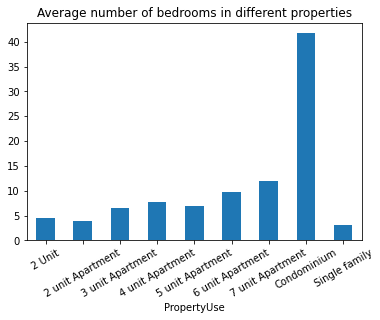

In [57]:
# simple bar plot: #bedrooms in apartments, #bedrooms in single fam, #bedrooms in condos
plot1_df = K12_df.groupby(["PropertyUse"]).mean()
plot1_df["Bedrooms"].plot.bar(title="Average number of bedrooms in different properties", rot=30)

Text(0, 0.5, 'Non-Apartment Property percentage')

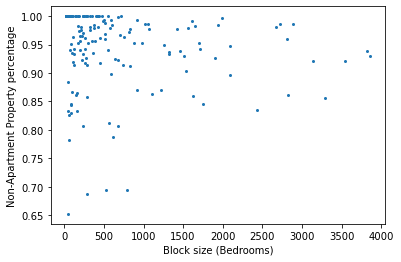

In [106]:
# x-axis is block size (in bedrooms), y-axis is percent of bedrooms in apartments
total_df = total_df.groupby(["NAME20"]).sum()
non_apt_df = K12_df.loc[(K12_df["PropertyUse"] == "Single family") | (K12_df["PropertyUse"] == "2 Unit") 
                        | (K12_df["PropertyUse"] == "Condominium")]
non_apt_df = non_apt_df.groupby(["NAME20"]).sum()
non_apt_p = non_apt_df["Bedrooms"] / total_df["Bedrooms"]
total_df["Non-Apt(%)"] = non_apt_p
ax = total_df.plot.scatter(x="Bedrooms", y="Non-Apt(%)", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("Non-Apartment Property percentage")

In [70]:
# x-axis is block size, y-axis is average age
# 有点麻烦，暂时不弄

Text(0, 0.5, 'K-12 children percentage')

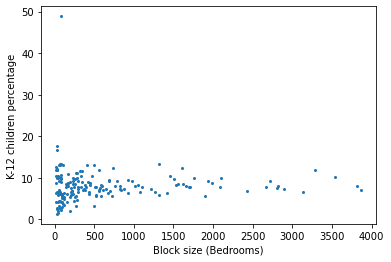

In [102]:
# x-axis is block size, y-axis is % who K-12
pop_df = K12_df.groupby(["NAME20", "GEO_ID", "Total"]).sum()
pop_df.reset_index(level=['Total'], inplace=True)
pop_df = pop_df.groupby(['NAME20']).sum()
pop_df["K-12(%)"] = 100* pop_df["K-12"] / pop_df["Total"]
ax = pop_df.plot.scatter(x="Bedrooms", y="K-12(%)", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("K-12 children percentage")

## Apartments That Have K-12 Kids

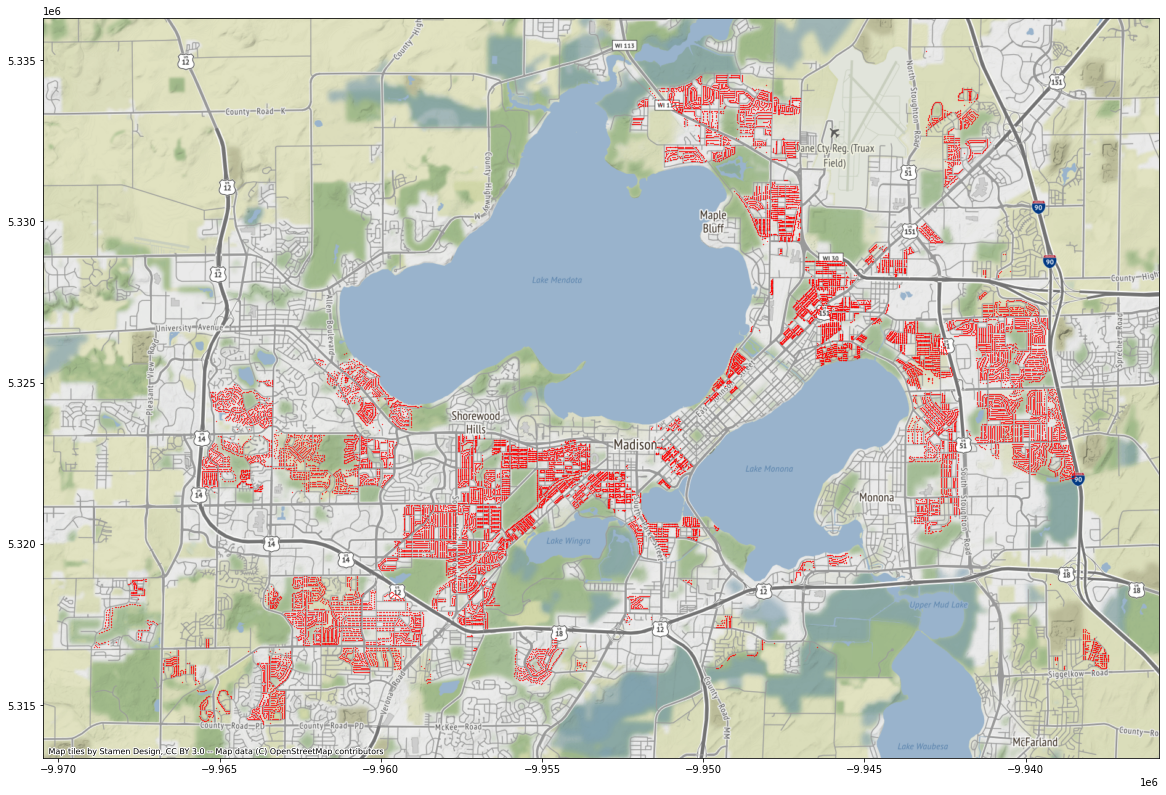

In [8]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Point size by K-12 kids number

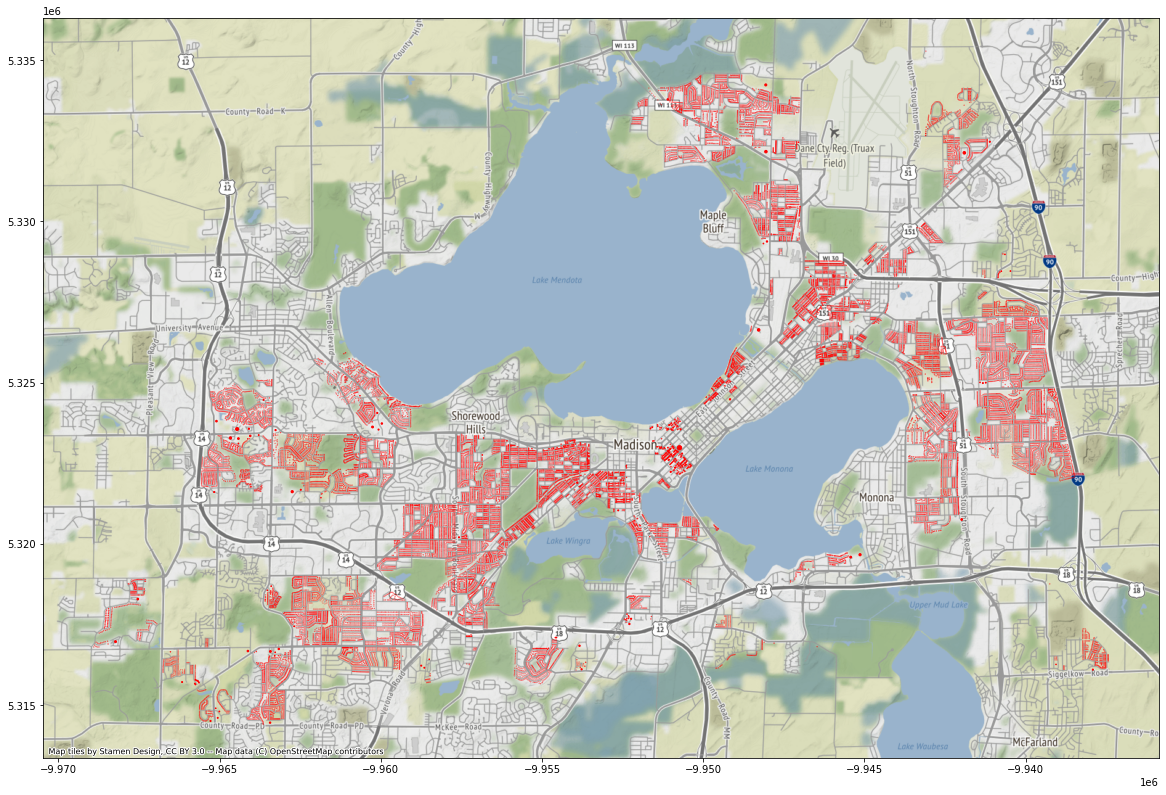

In [9]:
ax_k12_with_size = K12_df.plot(markersize=K12_df["K-12"]/4, figsize=(20,20), color="red")
ax3 = ctx.add_basemap(ax_k12_with_size)

## All Apartments in City of Madison

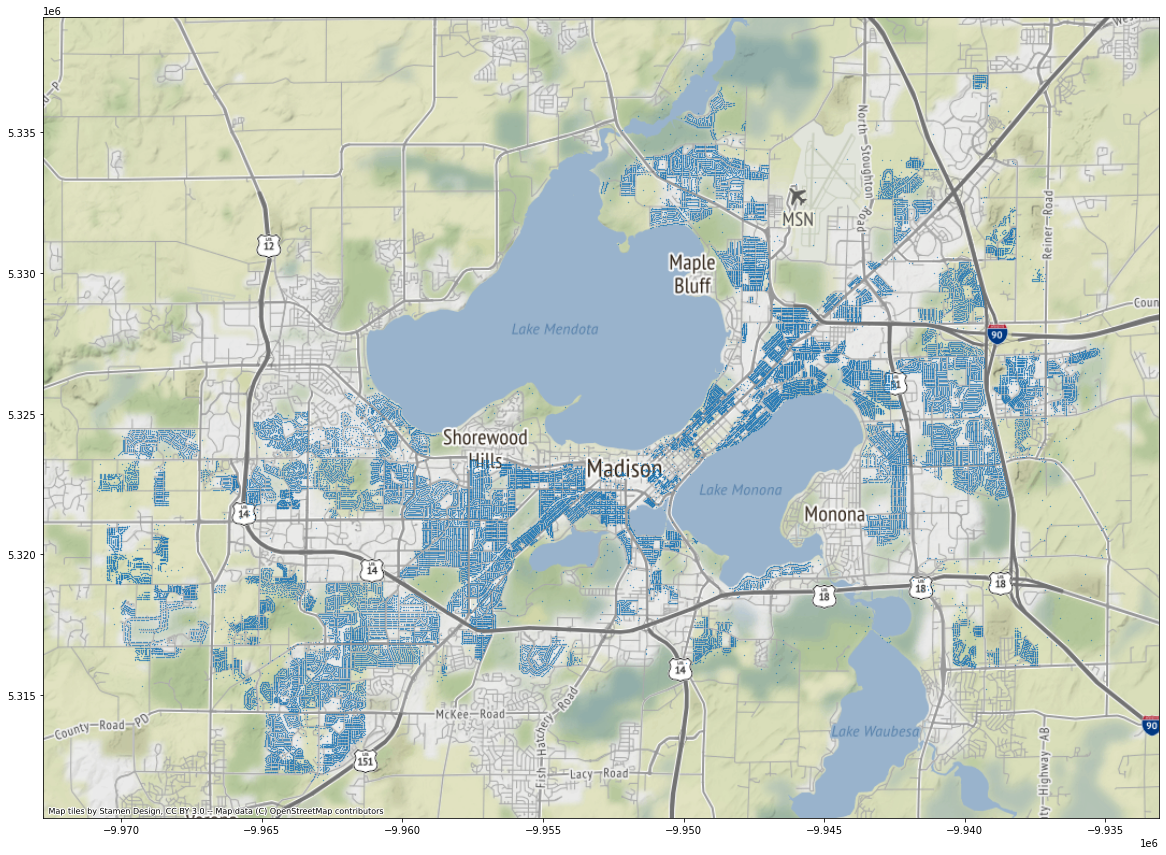

In [10]:
df = df.to_crs(epsg=3857)
ax = df.plot(markersize=0.1, figsize=(20,20))

ctx.add_basemap(ax)